In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'griddata', 'source', 'test', 'grid', 'exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
import pyhf
import logging
reload(pyhf)
reload(logging)

logging.basicConfig(level = logging.ERROR)


from pyhf import runOnePoint, hfpdf
def prep_data(observed_counts,backgrounds_incl_uncert,nominal_signals):
    b_counts = [b[0] for b in backgrounds_incl_uncert]
    b_uncerts = [b[1] for b in backgrounds_incl_uncert]
    
    pdf  = hfpdf.hepdata_like(nominal_signals, b_counts, b_uncerts)
    data = observed_counts + pdf.auxdata
    return data, pdf
    
def CLsOnePoint(muTest, observed_counts,backgrounds_incl_uncert,nominal_signals, init_pars,par_bounds):
    data, pdf = prep_data(observed_counts,backgrounds_incl_uncert,nominal_signals)
    clsobs, cls_exp = runOnePoint(muTest, data,pdf,init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

In [15]:
def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross

In [16]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)


{u'bindata': {u'sig': [10.0], u'bkg': [50.0], u'data': [55.0], u'bkgerr': [7.0]}, u'binning': [2, -0.5, 1.5]}
('val', 0.0023355788029574354)
ON MU=1
CLs: obs 0.450337178157 exp: [0.06154653039922158, 0.1472337570386738, 0.3227412178815565, 0.5995781547454528, 0.8636787737204704]
RUN SCAN


{'exp': [1.070397565798206,
  1.4420036447647087,
  2.0195346061497648,
  2.865953837042437,
  3.9631391175146797],
 'obs': 2.3880423878562675}

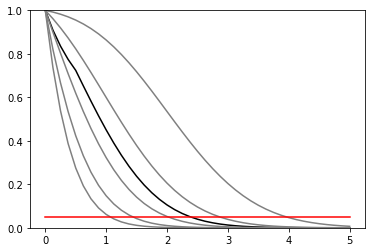

In [20]:
import json
source = json.load(open('./../../validation/data/1bin_example1.json'))

print (source)
# print json.dumps(source, indent=4)

my_observed_counts = source['bindata']['data']
my_background_counts = zip(source['bindata']['bkg'],source['bindata']['bkgerr'])
my_signal_counts = source['bindata']['sig']



d,pdf = prep_data(my_observed_counts,my_background_counts,my_signal_counts)

#init pars are mu + gammas 
init_pars = [1.0] + [1.0]*len(source['bindata']['bkg'])

print ('val', pdf.pdf(init_pars,d))

#parameter bounds for gammas is [0,10]
par_bounds = [[0,10]] + [[0,10]] * len(source['bindata']['bkg'])


pars = pyhf.constrained_bestfit(0.0,d,pdf,init_pars,par_bounds)

print( 'ON MU=1')
d = CLsOnePoint(1.0,my_observed_counts,my_background_counts,my_signal_counts,init_pars,par_bounds)
print( 'CLs: obs {} exp: {}'.format(*d))

print ('RUN SCAN')
mutests = np.linspace(0,5,41)
tests = [CLsOnePoint(muTest,my_observed_counts,my_background_counts,my_signal_counts,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)

invert_interval(mutests, cls_obs, cls_exp)

In [23]:
source = {
  "binning": [2,-0.5,1.5],
  "bindata": {
    "data":    [120.0, 180.0],
    "bkg":     [100.0, 150.0],
    "bkgerr":  [15.0, 20.0],
    "sig":     [30.0, 95.0]
  }
}

my_observed_counts = source['bindata']['data']
my_background_counts = zip(source['bindata']['bkg'],source['bindata']['bkgerr'])
my_signal_counts = source['bindata']['sig']
init_pars = [1.0] + [1.0 for b in my_background_counts]
par_bounds = [[0,10]] + [[0,10] for b,db in my_background_counts]

d,pdf = prep_data(my_observed_counts,my_background_counts,my_signal_counts)
from pyhf import hfpdf, unconstrained_bestfit

binning = source['binning']

nominal_nuis = [1.0 for b,db in my_background_counts]
nom_bonly = pdf.expected_data([0.0] + nominal_nuis, include_auxdata = False)

print nom_bonly



nom_sb = pdf.expected_data([1.0] + nominal_nuis, include_auxdata = False)

bestfit_pars = unconstrained_bestfit(d,pdf,init_pars,par_bounds)
bestfit_cts  = pdf.expected_data(bestfit_pars, include_auxdata = False)

def plot_histo(ax, binning, data):
    bin_width = (binning[2]-binning[1])/binning[0]
    bin_leftedges = np.linspace(binning[1],binning[2],binning[0]+1)[:-1]
    bin_centers = [le + bin_width/2. for le in bin_leftedges]
    ax.bar(bin_centers,data,1, alpha=0.5)


def plot_data(ax, binning, data):
    errors = [math.sqrt(d) for d in data]
    bin_width = (binning[2]-binning[1])/binning[0]
    bin_leftedges = np.linspace(binning[1],binning[2],binning[0]+1)[:-1]
    bin_centers = [le + bin_width/2. for le in bin_leftedges]    
    ax.bar(bin_centers,data,0, yerr=errors, linewidth=0, error_kw = dict(ecolor='k', elinewidth = 1))
    ax.scatter(bin_centers, data, c = 'k')


[100.0, 150.0]


(0, 300)

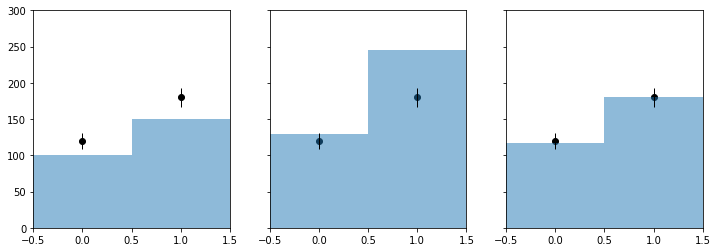

In [22]:
f,axarr = plt.subplots(1,3,sharey=True)
f.set_size_inches(12,4)

plot_histo(axarr[0], binning, nom_bonly)
plot_data(axarr[0], binning, my_observed_counts)
axarr[0].set_xlim(binning[1:])

plot_histo(axarr[1], binning, nom_sb)
plot_data(axarr[1], binning, my_observed_counts)
axarr[1].set_xlim(binning[1:])

plot_histo(axarr[2], binning, bestfit_cts)
plot_data(axarr[2], binning, my_observed_counts)
axarr[2].set_xlim(binning[1:])

plt.ylim(0,300)

In [9]:
##
##  DUMMY 2D thing
##

def signal(m1,m2):
    massscale = 150.
    minmass = 100.
    countscale = 2000
    
    effective_mass = np.sqrt(m1**2 + m2**2)
    return [countscale*np.exp(-(effective_mass-minmass)/massscale), 0]

def cls(m1,m2):
    signal_counts = signal(m1,m2)
    clsobs, clsexp = CLsOnePoint(1.0,my_observed_counts,my_background_counts,signal_counts,init_pars,par_bounds)[-2:]
    
    return clsobs, clsexp

In [10]:
nx, ny = 15,15
grid = grid_x, grid_y = np.mgrid[100:1000:complex(0,nx),100:1000:complex(0,ny)]
X = grid.T.reshape(nx * ny,2)
results = [cls(m1,m2) for m1,m2 in X]

/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:367: RuntimeWarning: divide by zero encountered in double_scalars
  CLs  = CLb/CLsb


In [11]:
yobs =  [obs    for obs, exp in results]
yexp = [[exp[i] for obs, exp in results] for i in range(5)]

(15, 15)


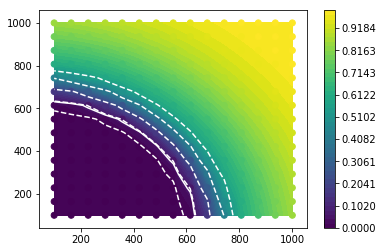

In [12]:
from scipy.interpolate import griddata
int_obs = griddata(X, yobs, (grid_x, grid_y), method='linear')

int_exp = [griddata(X, yexp[i], (grid_x, grid_y), method='linear') for i in range(5)]

print int_obs.shape


plt.contourf(grid_x, grid_y, int_obs, levels = np.linspace(0,1))
plt.colorbar()

plt.contour(grid_x, grid_y, int_obs, levels = [0.05], colors = 'w')
for level in int_exp:
    plt.contour(grid_x, grid_y, level, levels = [0.05], colors = 'w', linestyles = 'dashed')

plt.scatter(X[:,0],X[:,1], c = yobs, vmin = 0, vmax = 1)
